# Imports

In [183]:
#manipulação de dados
import pandas as pd
import numpy  as np

#visualização
import matplotlib.pyplot as plt
import seaborn           as sns
from IPython.core.display import HTML

#metricas
import sklearn.metrics
import scikitplot        as skplt
from scipy import stats

# processamento de dados
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import pickle

#modelos
from imblearn.ensemble       import BalancedRandomForestClassifier
from sklearn.linear_model import LinearRegression

In [184]:
from sklearn                 import cluster as c
from yellowbrick.cluster     import KElbowVisualizer, SilhouetteVisualizer
from sklearn.ensemble        import RandomForestRegressor 
from sklearn import decomposition as  dcp

## Helper functions

In [185]:
# configuração do jupyter notebook e plotagem de imagens
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    sns.set()
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [186]:
import warnings
warnings.filterwarnings("ignore")

In [187]:
def precision_at_k( data, k=200 ):
    """
    Object that return the precision at k  of recommended items in the top-k set that are relevant
    :param data: dataframe that will be calculated the precision at k position
    :param k: int, default=2000, position that the metric will be calculated default='2000'
    :return: a float value
    """
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']


def recall_at_k( data, k=200 ):
    """
    Object that return the recall at k  of recommended items in the top-k set that are relevant
    :param data: dataframe that will be calculated the recall at k position
    :param k: int, default=2000, position that the metric will be calculated default='2000'
    :return: a float value
    """
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']


def performace(model_name, data, y_val, yhat_class, k=200):
    """

    :param model_name: string, with the name of the algoritm that will be used
    :param data: dataframe sorted by  probabilit given to each iten by the model
    :param y_val: list of the target variable of the dataframe
    :param yhat_class: binary prediction made by the model for each iten
    :param k: int, default=2000 position that the metric will be calculated default='2000'
    :return: a dataframe with the metrics: [precision,recall, balanced accuracy, precision at k, recall at k]
    """
    import sklearn.metrics
    prec = sklearn.metrics.precision_score(y_val, yhat_class,average='macro')
    recal = sklearn.metrics.recall_score(y_val, yhat_class,average='macro')
    balanced_acc = sklearn.metrics.balanced_accuracy_score(y_val, yhat_class)
    recal_k = recall_at_k(data, k)
    prec_k = precision_at_k(data, k)

    return pd.DataFrame({'Model Name': model_name,
                         'Precison': prec,
                         'Recall': recal,
                         'Balanced_acc': balanced_acc,
                         'k': k,
                         'Precison at k': prec_k,
                         'Recall at k': recal_k}, index=[0])



In [188]:
def performace_cross_val(data, target, model, model_name, round_n=4, splits=3, shuffle_n=True, random=42, k=200):
    """
    this cross-validation object uses kfold with stratified folds and return the metrics
    :param data: dataframe
    :param target: string, name of the target variable
    :param model: model that will be used
    :param model_name: string with the model name
    :param round_n: int, default=5number of decimal points of the float values that will be returned
    :param splits: int, default=5, number of folds
    :param shuffle_n:bool, default=True, Whether to shuffle each class’s samples before splitting into batches
    :param random: int, default=42 controls the randomness of each fold
    :param k: int, default=2000 position that the metric will be calculated default='2000'
    :return: a dataframe with the mean and standard deviation of the metrics: [precision,recall, balanced accuracy, precision at k, recall at k]
    """
    import sklearn.model_selection as ms
    import sklearn.metrics
    import numpy as np
    skf = ms.StratifiedKFold(n_splits=splits, shuffle=shuffle_n, random_state=random)
    X = data
    y = X[target]
    X = X.drop(columns=[target, 'id'])
    precision = []
    recall = []
    balan_acc = []
    prec_k = []
    rec_k = []
    for train_index, test_index in skf.split(X, y):
        # train the model
        model.fit(X.iloc[train_index], y.iloc[train_index].values.ravel())

        # predict the classification
        yhat_class = model.predict(X.iloc[test_index])

        # predict the probabilit
        yhat_proba = model.predict_proba(X.iloc[test_index])

        # precision and recall
        prec = sklearn.metrics.precision_score(y.iloc[test_index], yhat_class,average='macro')
        rec = sklearn.metrics.recall_score(y.iloc[test_index], yhat_class,average='macro')
        balan_acc_score = sklearn.metrics.balanced_accuracy_score(y.iloc[test_index], yhat_class)
        precision.append(prec)
        recall.append(rec)
        balan_acc.append(balan_acc_score)

        # sort the test dataframe by the probabiliti score of the model
        aux = X.iloc[test_index]
        aux[target] = y.iloc[test_index]
        aux['score'] = yhat_proba[:, 1].tolist()

        # sorte by score
        aux = aux.sort_values('score', ascending=False)

        # precision and recall at k
        prec_k.append(precision_at_k(aux, k))
        rec_k.append(recall_at_k(aux, k))

    # return a dataset with the metrics
    return pd.DataFrame({'model name': model_name + " CV",
                        'precision_cv': np.round(np.mean(precision), round_n),
                        'prec_std': np.round(np.std(precision), round_n),
                        'recall_cv': np.round(np.mean(recall), round_n),
                        'rec_std': np.round(np.std(recall), round_n),
                        'balanced_acc_cv': np.round(np.mean(balan_acc), round_n),
                        'bal_std': np.round(np.std(balan_acc), round_n),
                        'k': k,
                        'precision_at_k_cv': np.round(np.mean(prec_k), round_n),
                        'perc_k_std': np.round(np.std(prec_k), round_n),
                        'recall_at_k_cv': np.round(np.mean(rec_k), round_n),
                        'rec_k_std': np.round(np.std(rec_k))}, index=[0])




# Load data 

In [189]:
path_local = 'C:/Users/Lavin/Documents/desafios/ifood/'

In [190]:
df7 = pd.read_csv(path_local + 'data/processed/df5.csv')

In [191]:
df7.head()

,id,marital_status,income,recency,mnt_wines,mnt_fruits,mnt_meat_products,mnt_fish_products,mnt_sweet_products,mnt_gold_prods,...,accepted_cmp3,accepted_cmp5,accepted_cmp1,age,n_family_members,days_since_signup,income_per_member,total_spent,total_accepted,response
0,5524,0.22,0.351086,0.585859,0.425318,0.442211,0.554878,0.664093,0.335878,0.274143,...,0,0,0,0.696429,1,0.948498,0.373613,0.639683,0,1
1,2174,0.22,0.277680,0.383838,0.007368,0.005025,0.006098,0.007722,0.003817,0.018692,...,0,0,0,0.750000,3,0.161660,0.094444,0.008730,0,0
2,4141,0.25,0.434956,0.262626,0.285332,0.246231,0.129065,0.428571,0.080153,0.130841,...,0,0,0,0.553571,2,0.446352,0.227577,0.305952,0,0
3,6182,0.25,0.155079,0.262626,0.007368,0.020101,0.020325,0.038610,0.011450,0.015576,...,0,0,0,0.214286,3,0.198856,0.051506,0.019048,0,0
4,5324,0.39,0.352051,0.949495,0.115874,0.216080,0.119919,0.177606,0.103053,0.046729,...,0,0,0,0.267857,3,0.230329,0.120491,0.165476,0,0


# Select columns 

**Para a segmentação de clientes algumas variaveis serão deixadas de lado nesse momento**

In [192]:
df_ref = df7[['id','response']]

In [193]:
cols_selected = ['id','income', 'recency', 'mnt_wines', 'mnt_fruits',
       'mnt_meat_products', 'mnt_fish_products', 'mnt_sweet_products',
       'mnt_gold_prods', 'num_deals_purchases', 'num_web_purchases',
       'num_catalog_purchases', 'num_store_purchases', 'num_web_visits_month',
       'age','n_family_members', 'days_since_signup', 'income_per_member',
       'total_spent']
df8 = df7[cols_selected]

# Estudo do espaço

In [194]:
X = df8.copy()
X = X.drop(columns='id')

## PCA

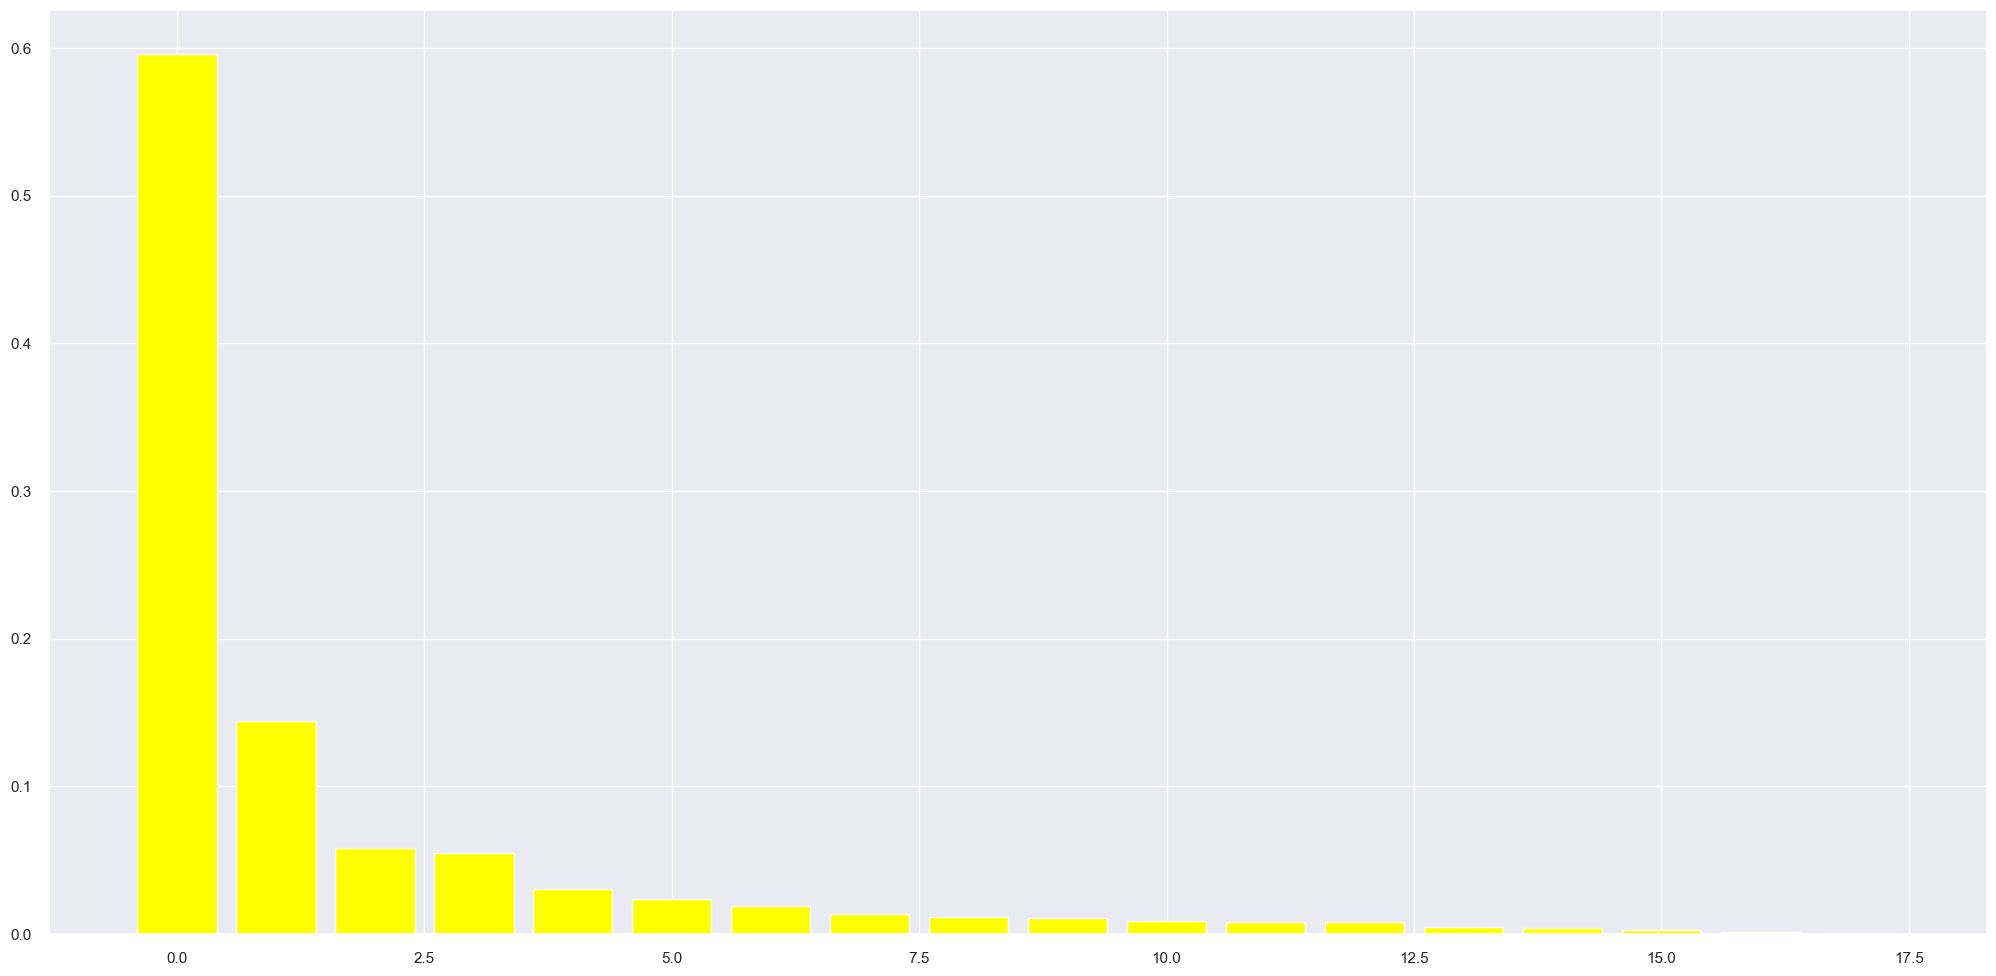

In [195]:
pca = dcp.PCA(n_components = X.shape[1])
principal_component = pca.fit_transform(X)

# plot explained variable

features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_,color='yellow')

#pcs componentes
df_pca = pd.DataFrame(principal_component)

<AxesSubplot: xlabel='0', ylabel='1'>

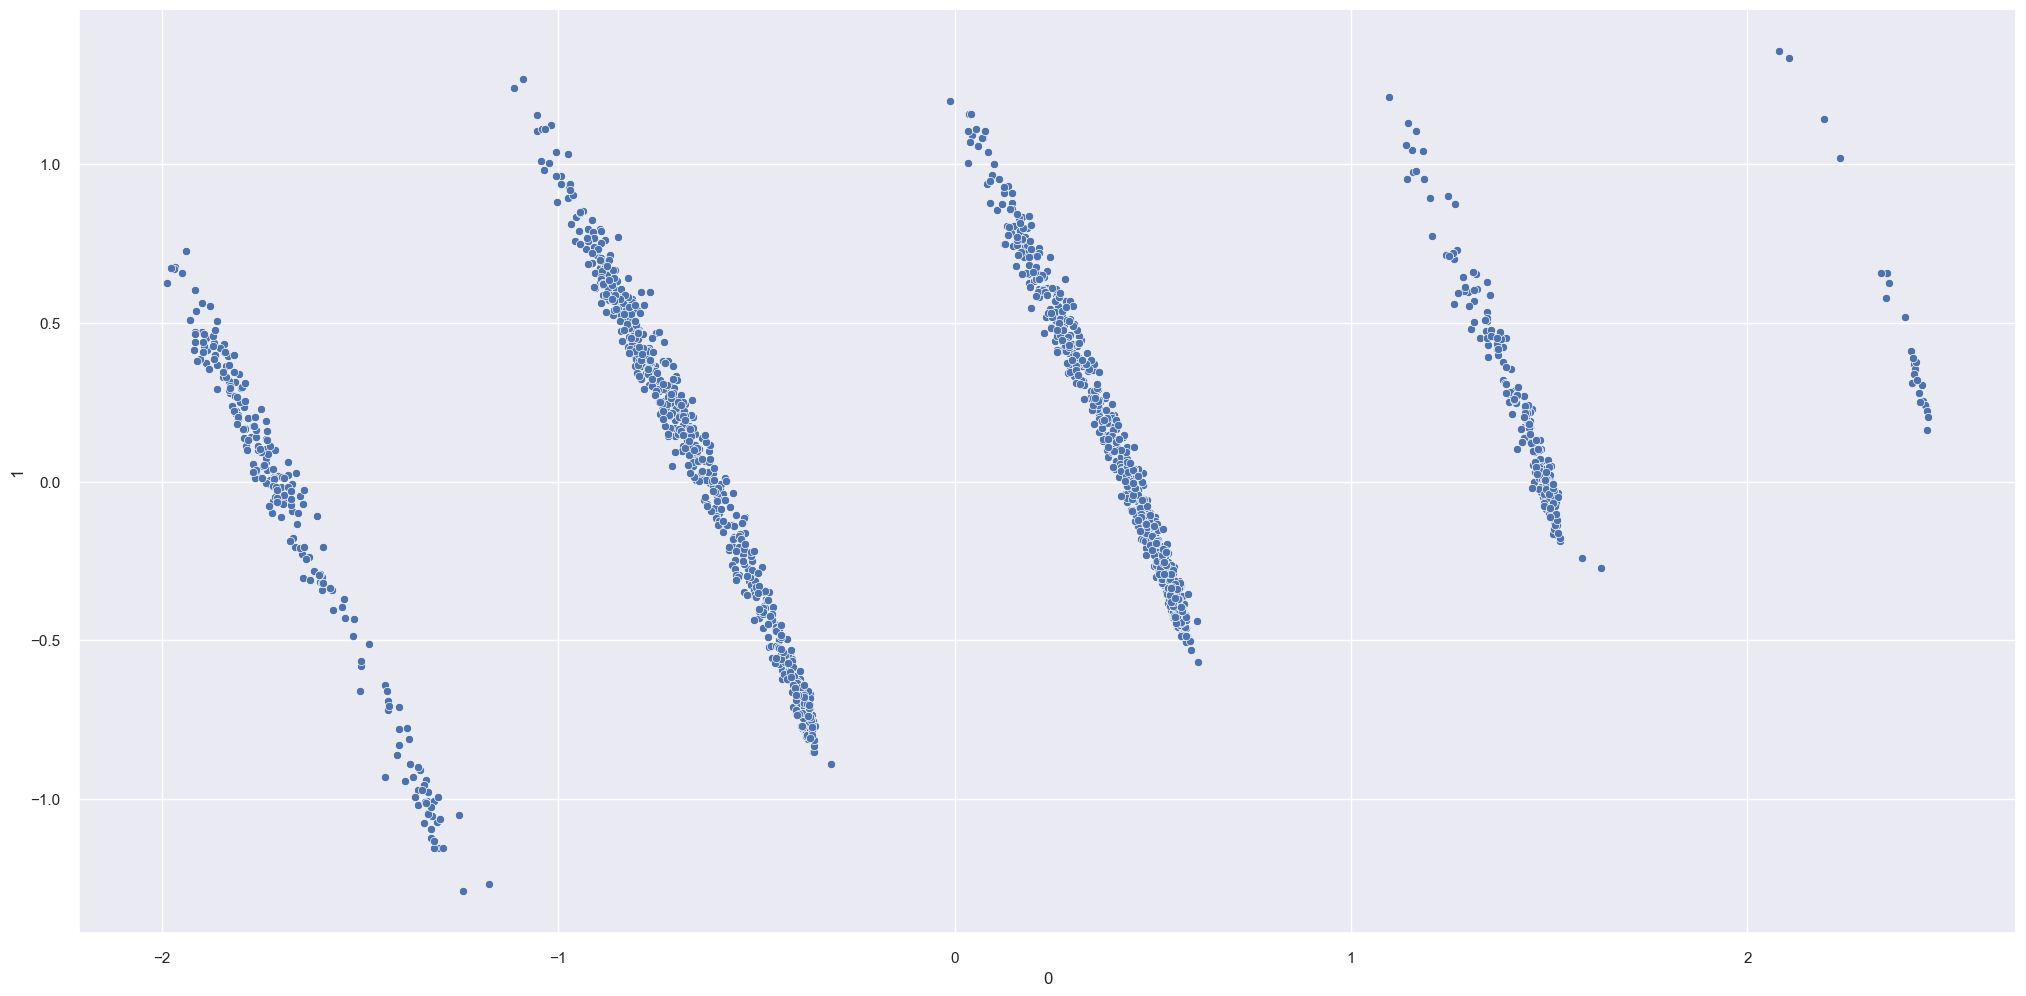

In [196]:
sns.scatterplot(x=0,y=1,data=df_pca)

## Umap

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

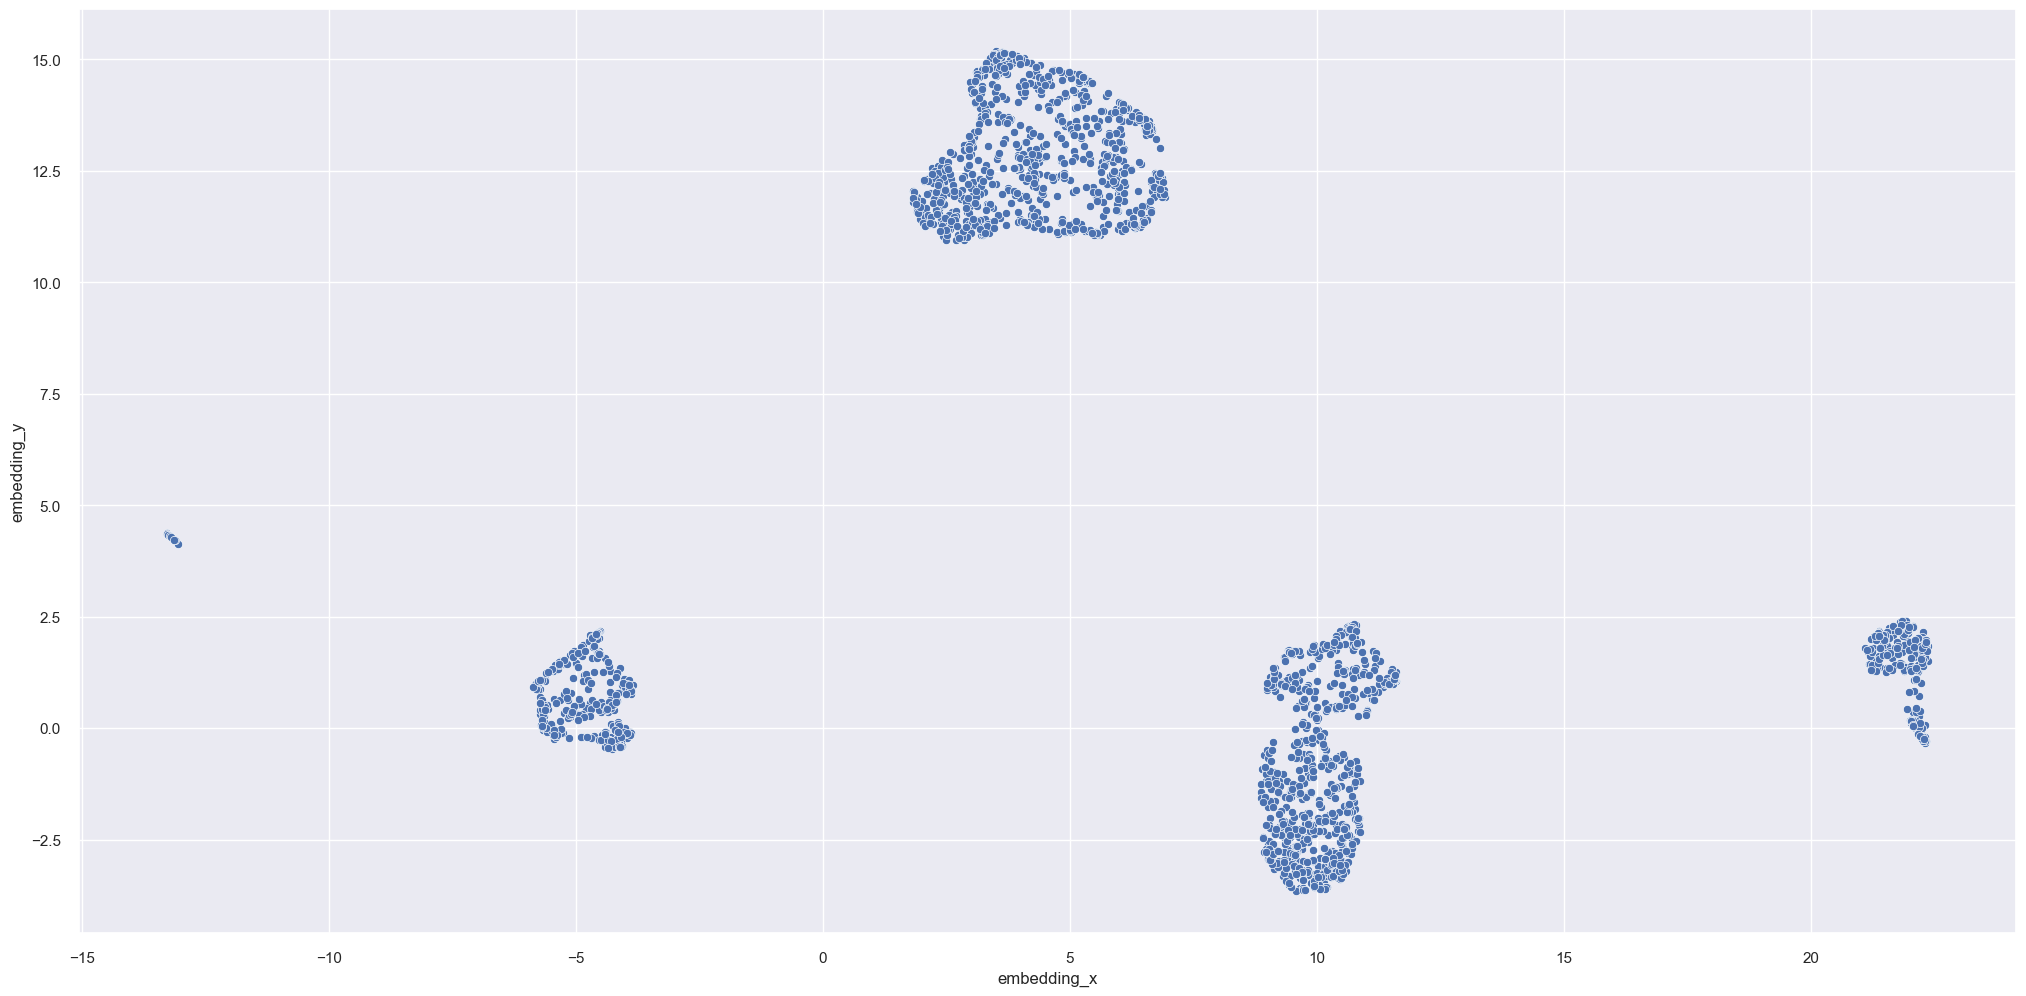

In [197]:
import umap.umap_ as umap
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)


#embedding
df_umap = pd.DataFrame()

df_umap['embedding_x'] = embedding[:,0]
df_umap['embedding_y'] = embedding[:,1]


sns.scatterplot(x='embedding_x', y ='embedding_y',data=df_umap)

## T-SNE

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

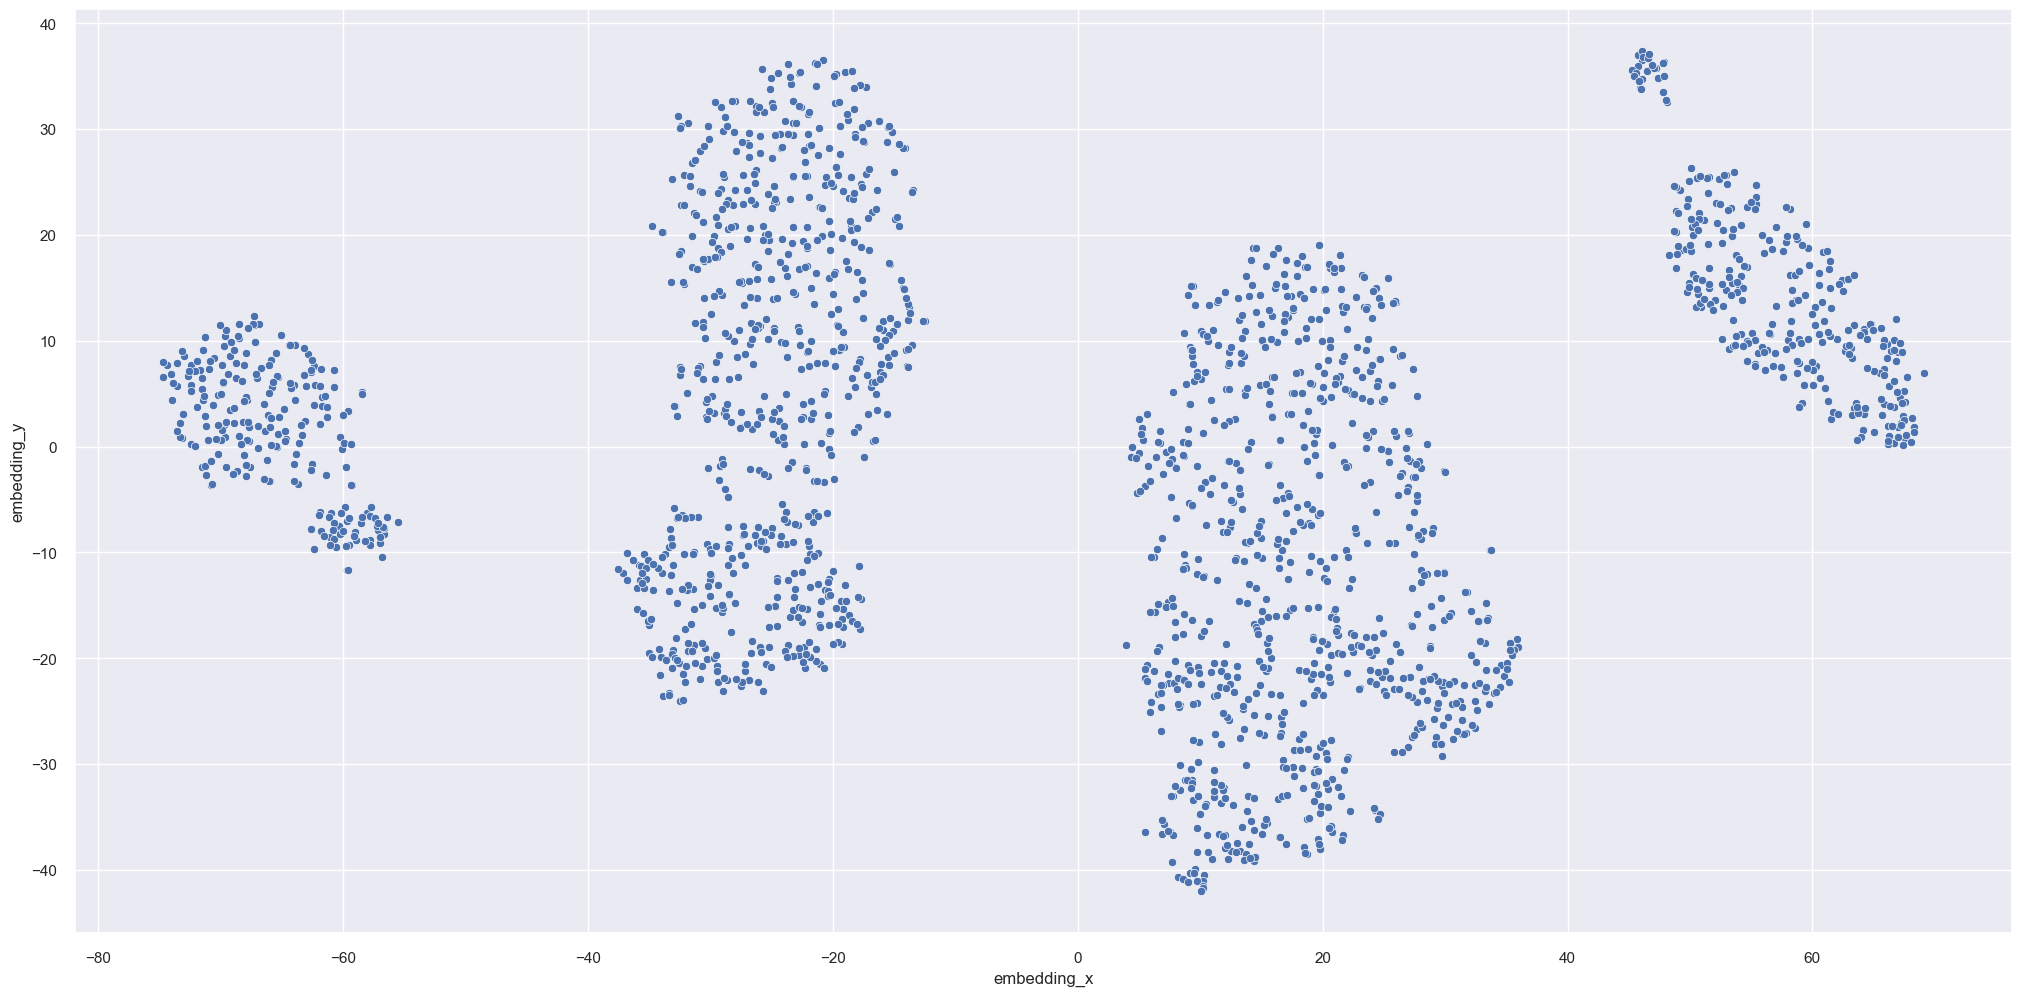

In [198]:
from sklearn.manifold import TSNE
reducer = TSNE(n_components=2,n_jobs=-1,random_state=42)
embedding = reducer.fit_transform(X)


#embedding
df_tsne = pd.DataFrame()

df_tsne['embedding_x'] = embedding[:,0]
df_tsne['embedding_y'] = embedding[:,1]


sns.scatterplot(x='embedding_x', y ='embedding_y',data=df_tsne)

## tree-based embedign

In [199]:
X = df8.drop(['id','total_spent'],axis=1)
y = df8['total_spent']


# model definition
rf_model = RandomForestRegressor(n_estimators=100,random_state=42)

#model training
rf_model.fit(X,y.values)

# Leaf
df_leaf = pd.DataFrame(rf_model.apply(X))
#dataframe Leaf

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

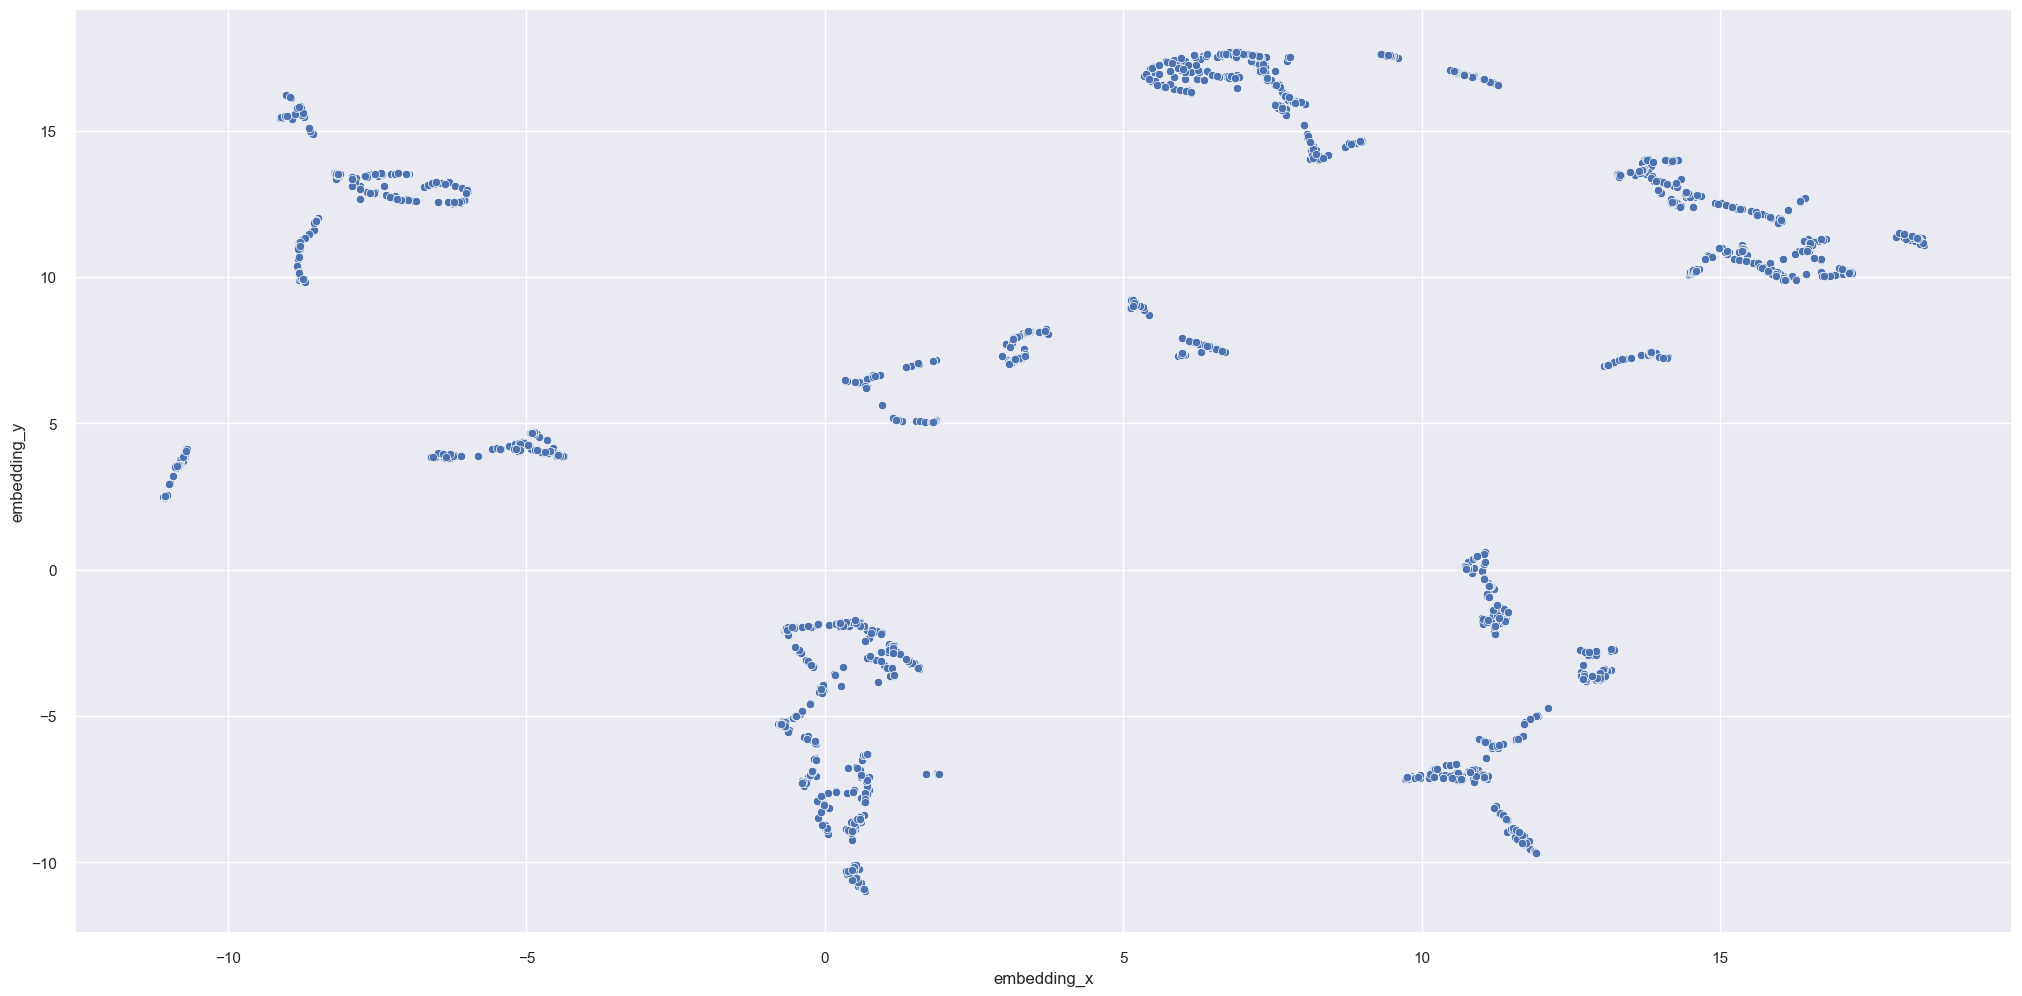

In [200]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_leaf)


#embedding

df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]


sns.scatterplot(x='embedding_x', y ='embedding_y',data=df_pca)

# Fine tuning 

In [216]:
X =df_pca
X.columns = X.columns.astype(str)

In [217]:
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,embedding_x,embedding_y
0,-1.832839,0.395714,0.358618,-0.160608,0.084925,-0.438221,0.336270,0.204020,-0.085811,0.032618,-0.251078,0.097929,0.153204,-0.018952,0.071422,-0.047801,-0.060531,2.855422e-15,-0.421425,-4.907897
1,0.558435,-0.373100,-0.313275,0.133115,-0.191388,-0.223621,0.097237,0.002149,-0.003700,-0.016000,-0.005459,0.006826,-0.000789,0.027621,-0.039282,-0.012409,0.028319,1.362850e-16,10.776932,-6.861798
2,-0.657342,0.074567,-0.220487,-0.130767,-0.059579,-0.031288,-0.308920,-0.065977,-0.005657,0.168443,-0.057460,-0.147772,-0.046726,0.057434,0.122177,0.029394,0.015768,-6.133468e-16,-8.677056,11.392971
3,0.555115,-0.415908,-0.324944,-0.028487,0.194997,0.161440,-0.037690,-0.018055,-0.008967,0.029125,-0.013574,-0.004761,0.021998,-0.046448,-0.016225,0.020963,-0.027487,2.247120e-15,16.268297,9.927471
4,0.406670,0.065059,0.080833,0.506705,0.208742,0.130245,-0.104679,0.049009,-0.000751,-0.044023,-0.140844,0.070059,0.117572,0.118994,0.003187,0.017121,0.032640,5.655205e-16,5.250387,9.056093


In [218]:
clusters = [2,3,4,5,6,7]

## k-means

In [220]:
sil_k = []
from sklearn                 import cluster as c
for k in clusters:
    # model definition
    k_model = c.KMeans(n_clusters=k)

    #model training
    k_model.fit(X)

    #model predict
    labels = k_model.predict(X)

    #model performace
    sil_k.append(sklearn.metrics.silhouette_score(X,labels,metric='euclidean'))

In [221]:
sil_k

[0.4232744153222079,
 0.5324557002062393,
 0.5566235830760373,
 0.5509498715157704,
 0.613646377141048,
 0.6497927025775082]

In [222]:
wss = []
for k in clusters:
    # model definition
    kmeans = c.KMeans(init='random', n_clusters=k, n_init=10,max_iter=300,random_state=42)
    #model training
    kmeans.fit(X)
    
    wss.append(kmeans.inertia_)

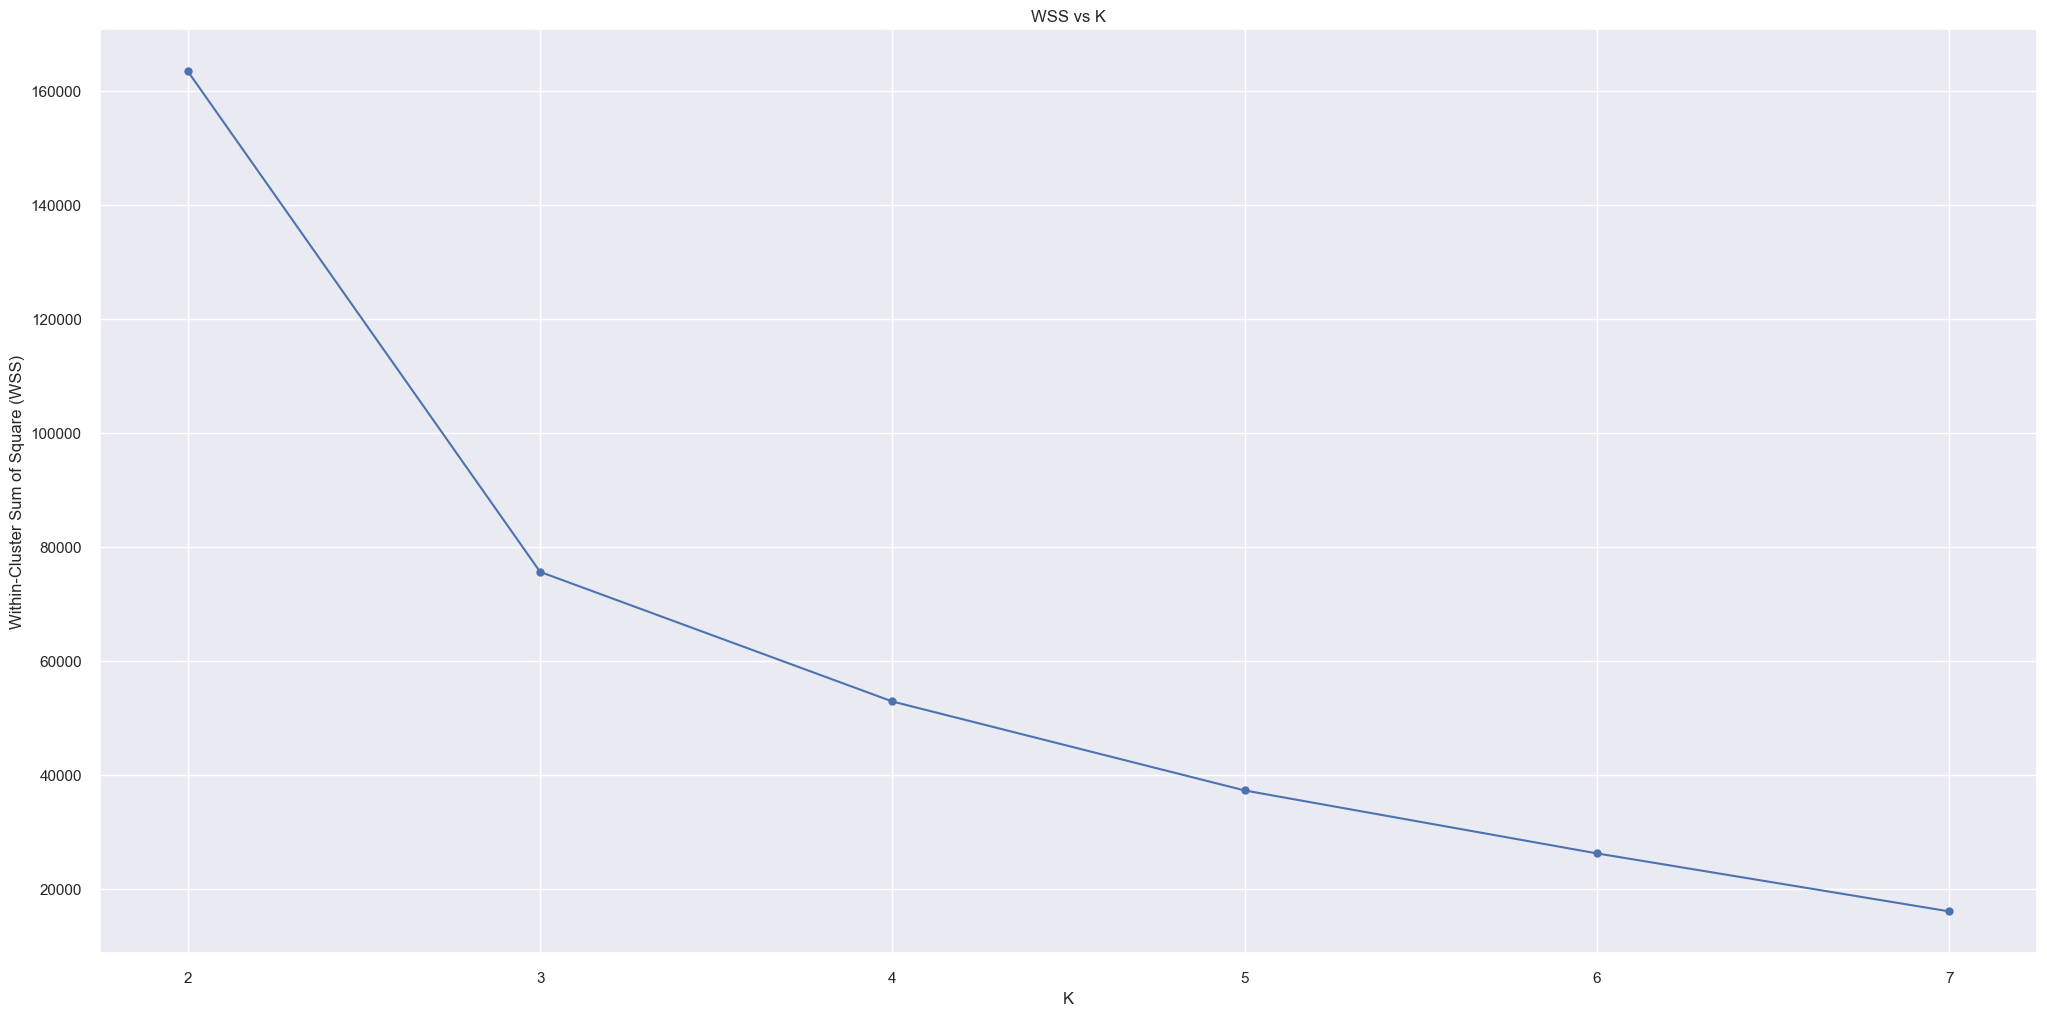

In [223]:
plt.plot(clusters,wss, marker = 'o');
plt.xlabel('K');
plt.ylabel('Within-Cluster Sum of Square (WSS)');
plt.title('WSS vs K');

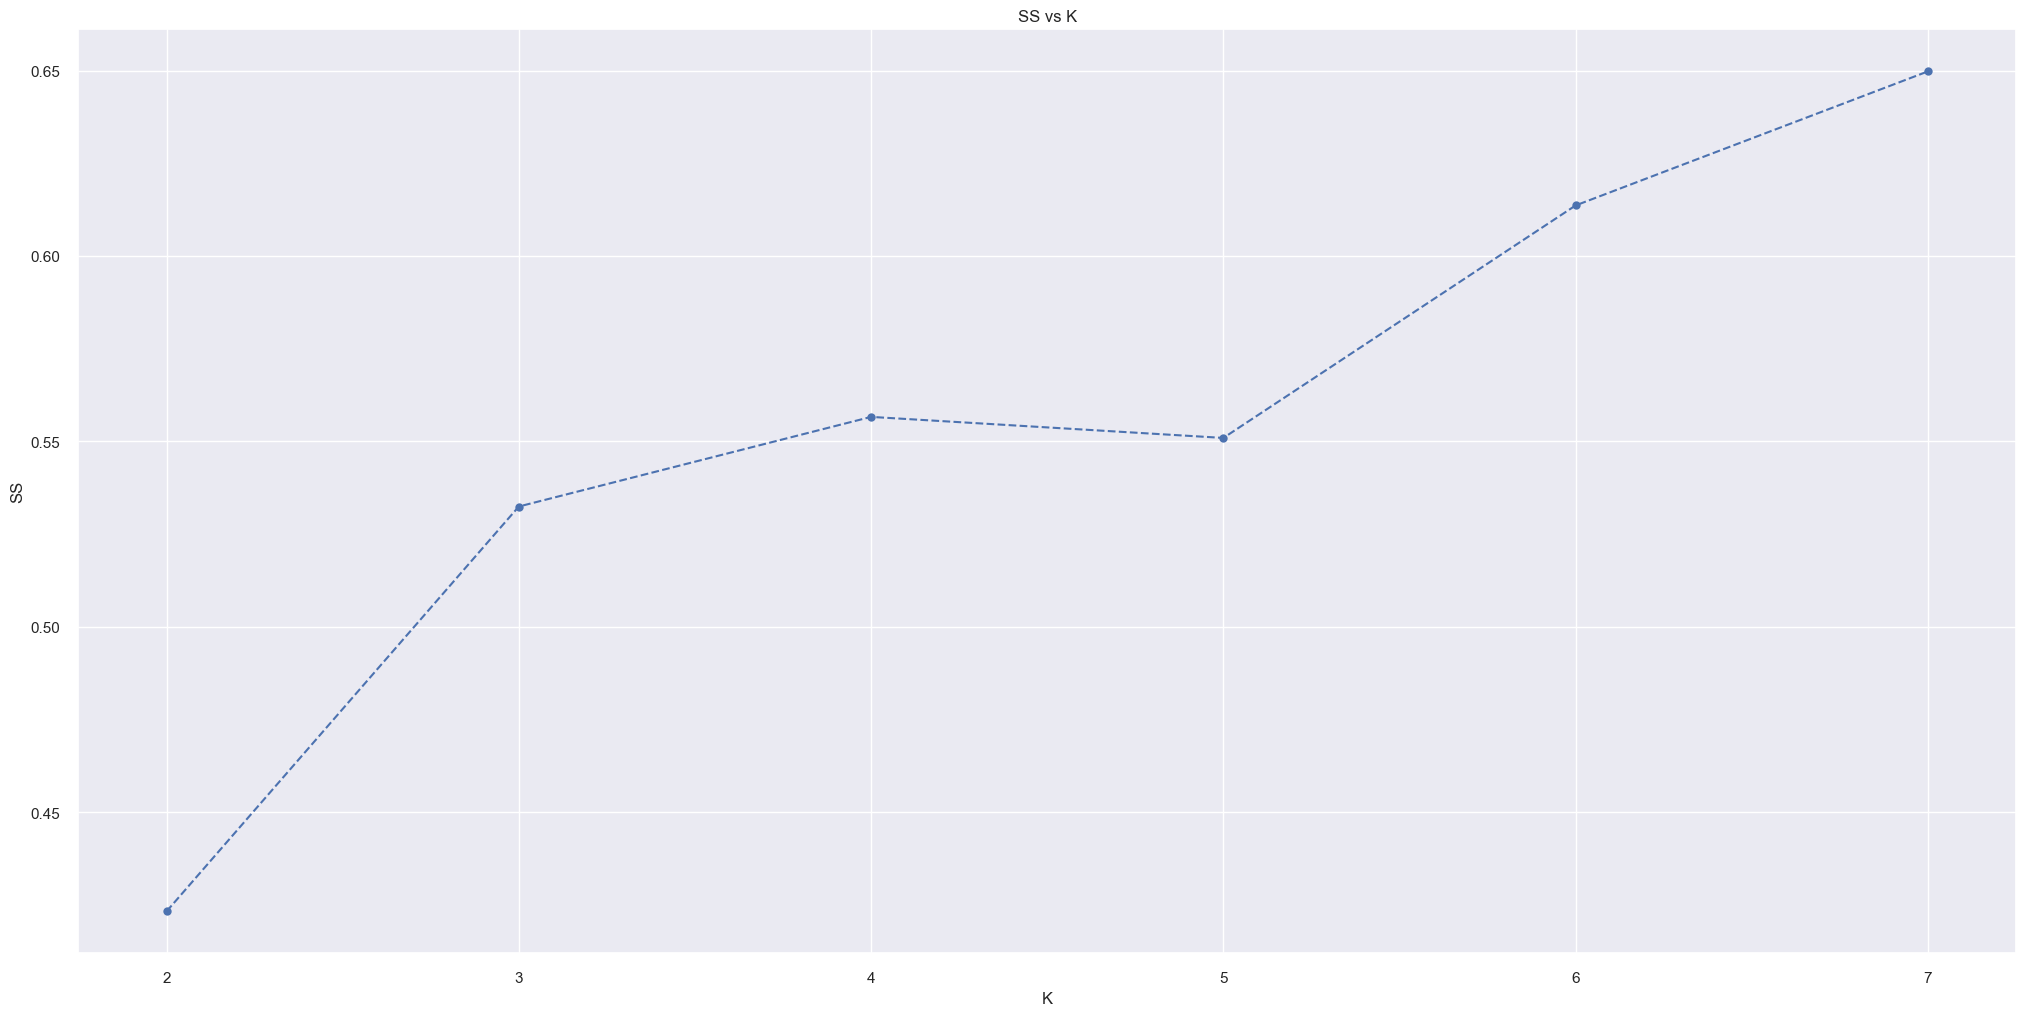

In [224]:
plt.plot(clusters,sil_k,linestyle='--',marker = 'o');
plt.xlabel('K');
plt.ylabel('SS');
plt.title('SS vs K');

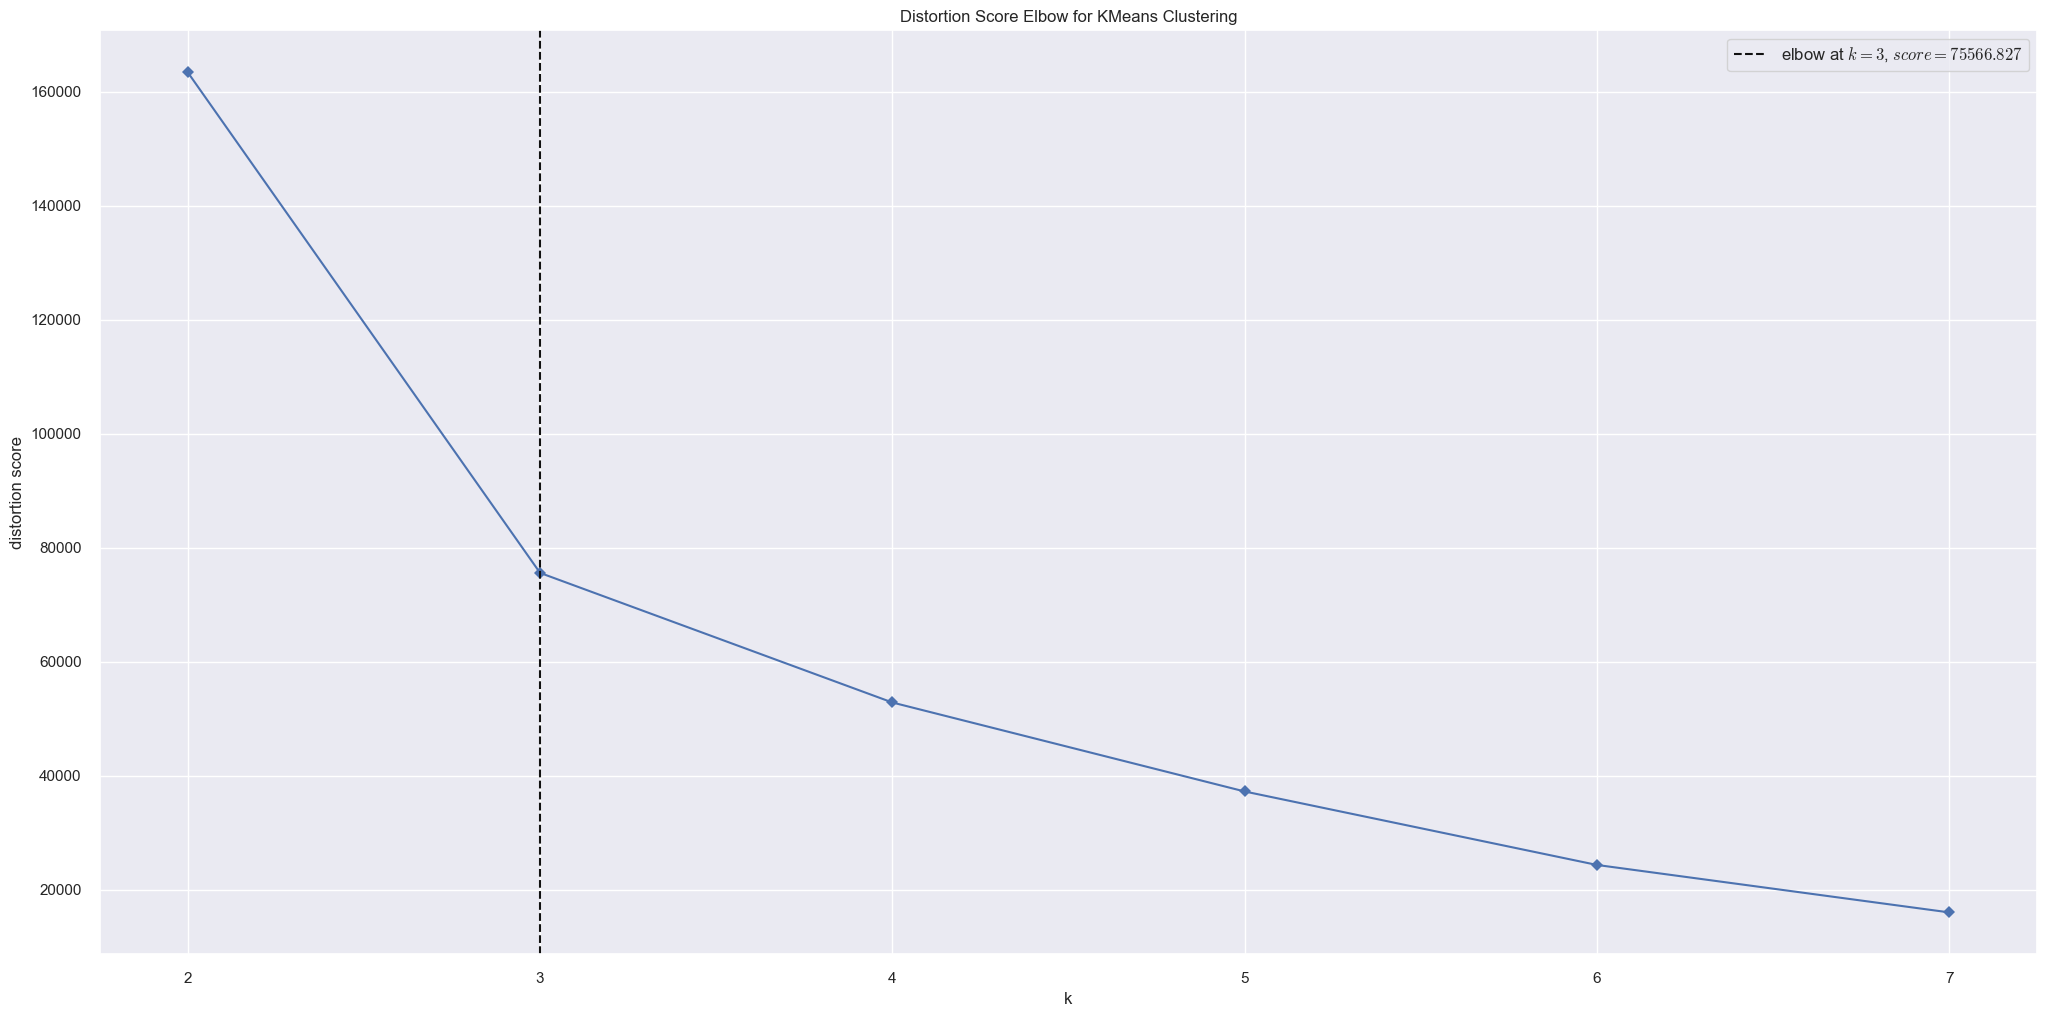

In [225]:
kmeans = KElbowVisualizer(c.KMeans(),k=clusters,timings=False)
kmeans.fit(X)
kmeans.show();

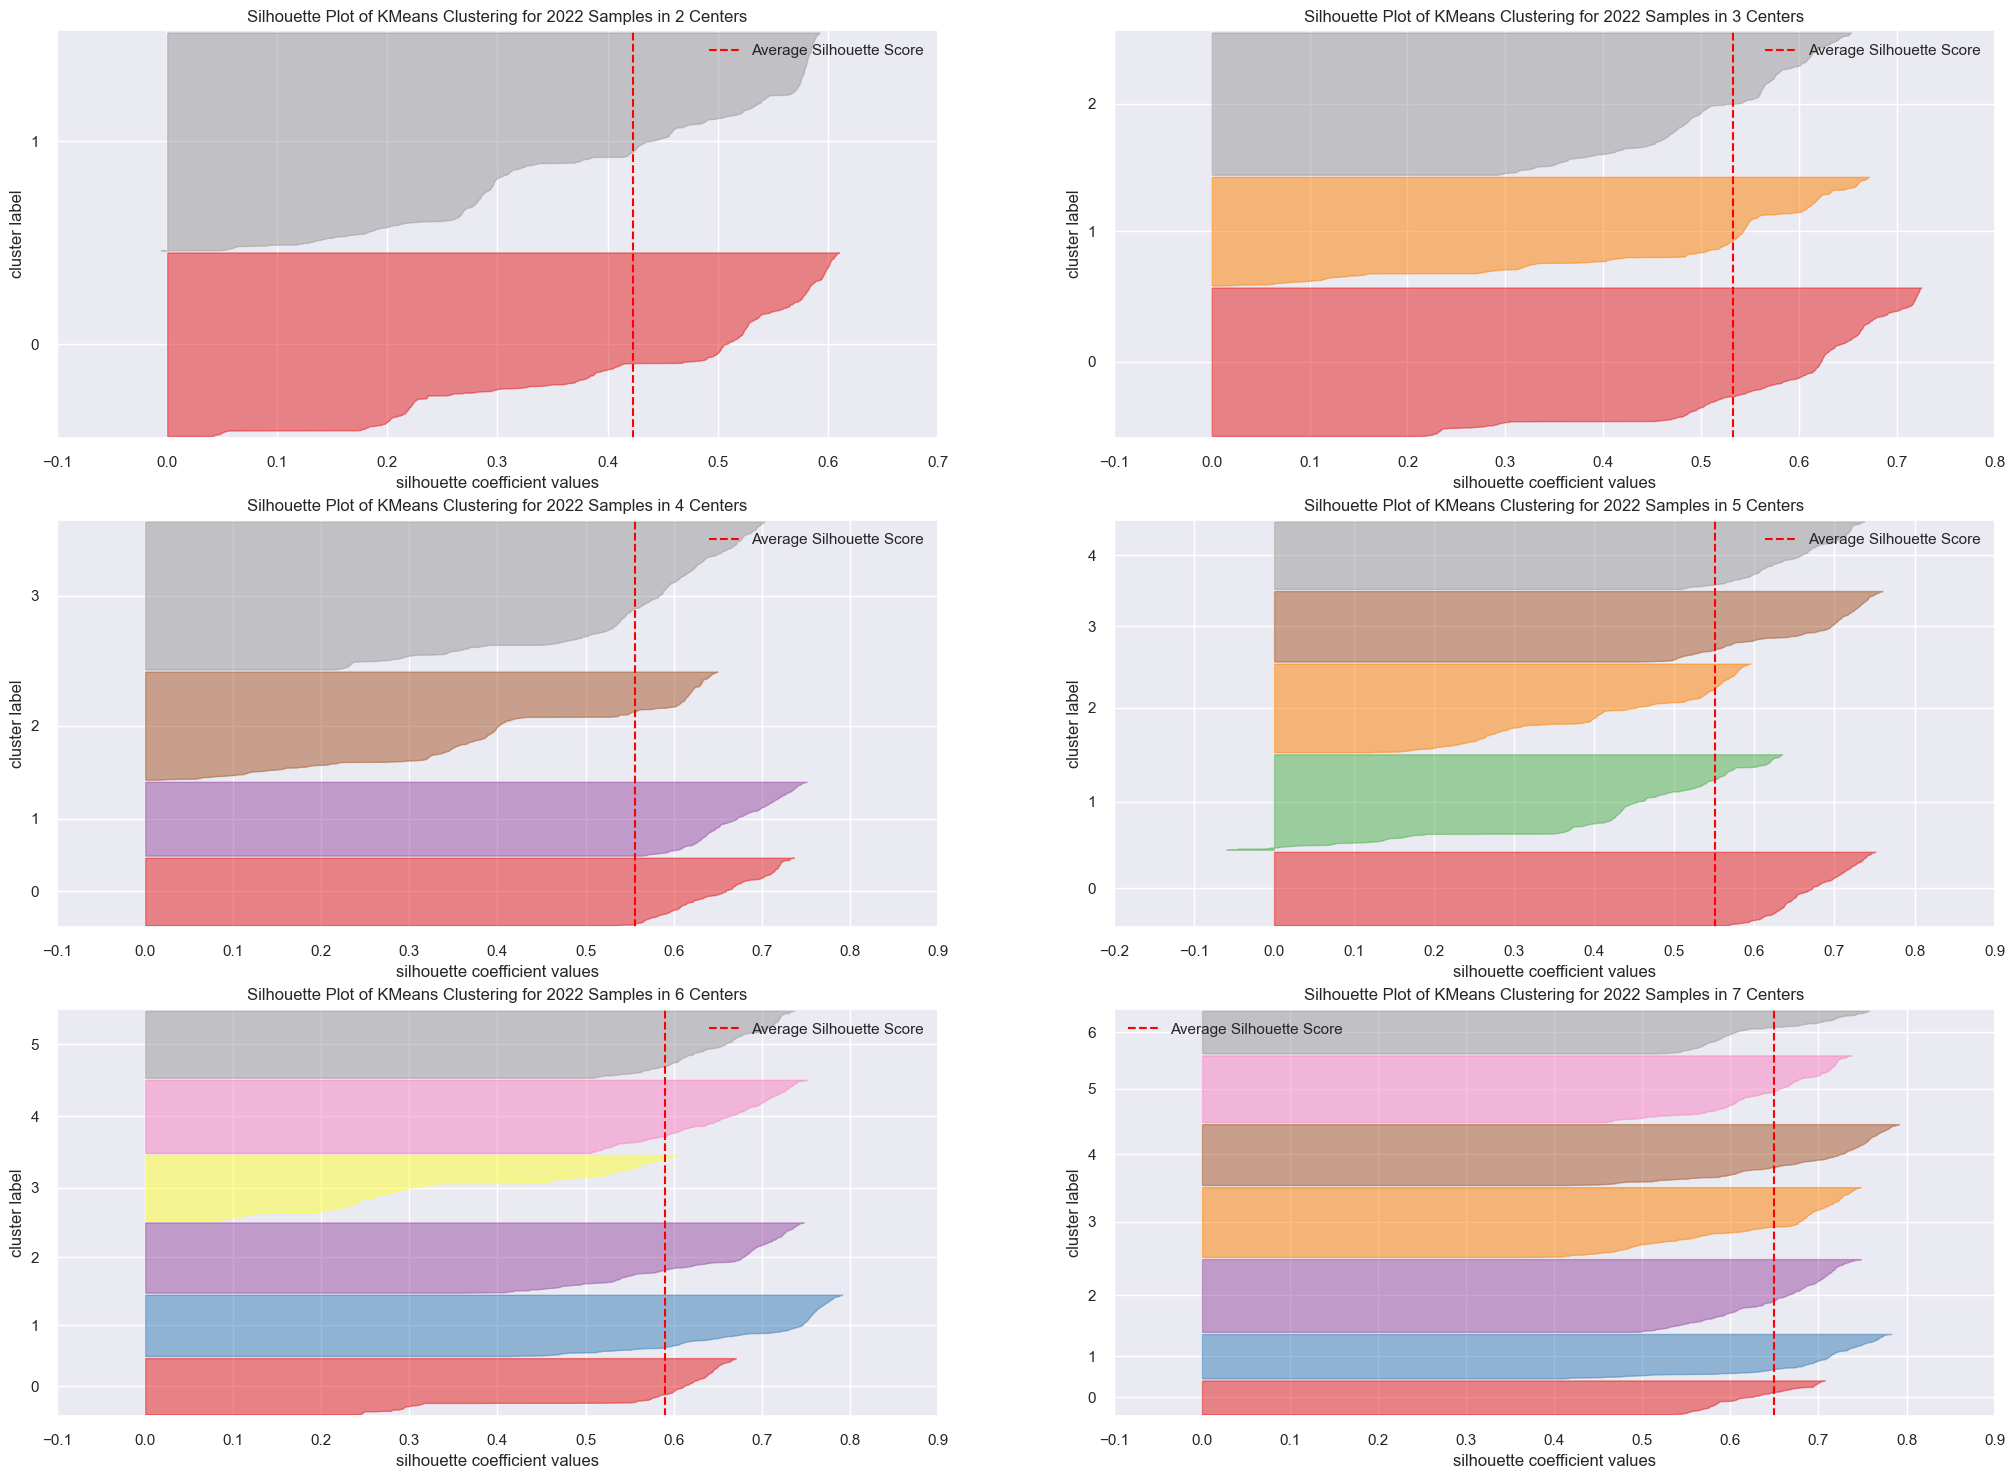

In [226]:
fig, ax = plt.subplots(3,2,figsize=(25,18))
#k=2
for k in clusters:
    from sklearn import cluster as c
    km = c.KMeans(n_clusters=k,init='random',n_init=10, max_iter=100,random_state=42)
    l,c = divmod(k,2)
    visualizer = SilhouetteVisualizer(km, color='yellowbrick',ax=ax[l-1][c])
    visualizer.fit(X)
    visualizer.finalize()